In [5]:
# I consider dataset as ds, dataframe as df, model as mdl, images as imgs, labels as lbls
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import timm  
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

CONFIG = {
    'IMG_PATH': "/kaggle/input/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img",
    'CSV_PATH': "/kaggle/input/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/IND_and_Nep_AQI_Dataset.csv",
    
    'IMG_SIZE': (224, 224),
    'BATCH_SIZE': 32,
    'NUM_CLASSES': 6,
    'EPOCHS': 15,
    'DEVICE': 'cuda' if torch.cuda.is_available() else 'cpu',
    'SEED': 42
}

print(f"Device set to: {CONFIG['DEVICE']}")
if os.path.exists(CONFIG['CSV_PATH']):
    print(f"CSV found at: {CONFIG['CSV_PATH']}")
else:
    print(f"Still can't find CSV at: {CONFIG['CSV_PATH']}")

Device set to: cuda
CSV found at: /kaggle/input/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/IND_and_Nep_AQI_Dataset.csv


In [6]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.csv'):
            print(os.path.join(dirname, filename))

/kaggle/input/Dataset_for_AQI_Classification/Dataset_for_AQI_Classification/val_data.csv
/kaggle/input/Dataset_for_AQI_Classification/Dataset_for_AQI_Classification/testing_data.csv
/kaggle/input/Dataset_for_AQI_Classification/Dataset_for_AQI_Classification/train_data.csv
/kaggle/input/Dataset_for_AQI_Classification/Dataset_for_AQI_Classification/Sample result file.csv
/kaggle/input/Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/Nepal/Biratnagar/Biratnagar_AQI_All_info.csv
/kaggle/input/Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/India/Greater_Noida/KPIII_UP_AQI_All.csv
/kaggle/input/Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/India/Dimapur/Dimapur_AQI_All_Info.csv
/kaggle/input/Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/India/Bengaluru/Bengaluru_AQI_All_info.csv
/kaggle/input/Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/India

In [7]:
def preprocess_dataframe(csv_path):
    """
    Loads and cleans the dataframe (df).
    - [cite_start]Fixes class names [cite: 20]
    - [cite_start]Cyclic encoding for time [cite: 49]
    - [cite_start]Normalizes tabular features [cite: 48]
    """
    df = pd.read_csv(csv_path)
    
    # Clean class names (remove prefixes like 'a_', 'b_', etc.)
    df['AQI_Class'] = df['AQI_Class'].astype(str).str.replace(r'^[a-f]_', '', regex=True)
    df['AQI_Class'] = df['AQI_Class'].str.replace('_', ' ')
    
    # Map classes to integers
    class_map = {
        'Good': 0, 'Moderate': 1, 'Unhealthy for Sensitive Groups': 2,
        'Unhealthy': 3, 'Very Unhealthy': 4, 'Severe': 5
    }
    df['label'] = df['AQI_Class'].map(class_map)
    
    # Drop rows where label mapping failed
    df = df.dropna(subset=['label'])
    df['label'] = df['label'].astype(int)
    
    # Ensure numeric types for sensors
    numeric_cols = ['AQI', 'PM2.5', 'PM10', 'Hour', 'Month', 'Day']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    # [cite_start]Cyclic Encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24.0)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24.0)
    df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12.0)
    df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12.0)
    df['day_sin'] = np.sin(2 * np.pi * df['Day'] / 31.0) 
    df['day_cos'] = np.cos(2 * np.pi * df['Day'] / 31.0)
    
    feature_cols = ['AQI', 'PM2.5', 'PM10', 'hour_sin', 'hour_cos', 
                    'month_sin', 'month_cos', 'day_sin', 'day_cos']
    
    # Normalize features (Z-Score)
    scaler = StandardScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])
    
    return df, feature_cols, class_map

df, feature_cols, class_map = preprocess_dataframe(CONFIG['CSV_PATH'])
print(f"Data Loaded. Shape: {df.shape}")
print(f"Features used: {feature_cols}")

Data Loaded. Shape: (12240, 21)
Features used: ['AQI', 'PM2.5', 'PM10', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [8]:
class AirPollutionDataset(Dataset):
    """
    Custom PyTorch Dataset handling both Images and Tabular data.
    """
    def __init__(self, df, img_dir, feature_cols, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.feature_cols = feature_cols
        self.transform = transform
        self.img_filenames = df['Filename'].values
        self.tab_features = df[feature_cols].values.astype(np.float32)
        self.labels = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.img_filenames[idx]
        img_path = os.path.join(self.img_dir, img_name)
        
        # Open image (Handle potential errors)
        try:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            # Fallback for missing images (creates a black image)
            image = np.zeros((224, 224, 3), dtype=np.uint8)
            
        # 2. Apply Augmentations (Albumentations)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        # 3. Get Tabular Features
        tab_data = torch.tensor(self.tab_features[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return image, tab_data, label

def get_transforms(data='train'):
    if data == 'train':
        return A.Compose([
            A.Resize(*CONFIG['IMG_SIZE']),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.GaussNoise(var_limit=(10, 50), p=0.2), # Atmospheric simulation
            A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, p=0.2), # Haze/Fog
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(*CONFIG['IMG_SIZE']),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=CONFIG['SEED'])
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label'], random_state=CONFIG['SEED'])

train_ds = AirPollutionDataset(train_df, CONFIG['IMG_PATH'], feature_cols, transform=get_transforms('train'))
val_ds = AirPollutionDataset(val_df, CONFIG['IMG_PATH'], feature_cols, transform=get_transforms('val'))
test_ds = AirPollutionDataset(test_df, CONFIG['IMG_PATH'], feature_cols, transform=get_transforms('val'))

train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2)

print(f"Datasets Ready. Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Datasets Ready. Train: 9792, Val: 1224, Test: 1224


# **Image Branch Only (EfficientNet)**

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]


STARTING STAGE 1: FEATURE EXTRACTION (Frozen Backbone)
Epoch 1/15 | Train Loss: 1.1856 | Val Loss: 0.6572 | Train Acc: 53.05% | Val Acc: 76.96%
Epoch 2/15 | Train Loss: 0.8708 | Val Loss: 0.4855 | Train Acc: 65.88% | Val Acc: 82.92%
Epoch 3/15 | Train Loss: 0.7796 | Val Loss: 0.4125 | Train Acc: 69.77% | Val Acc: 85.29%
Epoch 4/15 | Train Loss: 0.7089 | Val Loss: 0.3584 | Train Acc: 72.37% | Val Acc: 86.76%
Epoch 5/15 | Train Loss: 0.6848 | Val Loss: 0.3032 | Train Acc: 73.30% | Val Acc: 89.13%
Epoch 6/15 | Train Loss: 0.6494 | Val Loss: 0.2972 | Train Acc: 74.93% | Val Acc: 89.46%
Epoch 7/15 | Train Loss: 0.6205 | Val Loss: 0.2592 | Train Acc: 76.03% | Val Acc: 90.85%
Epoch 8/15 | Train Loss: 0.6031 | Val Loss: 0.2342 | Train Acc: 76.44% | Val Acc: 91.83%
Epoch 9/15 | Train Loss: 0.5865 | Val Loss: 0.2279 | Train Acc: 77.36% | Val Acc: 92.32%
Epoch 10/15 | Train Loss: 0.5790 | Val Loss: 0.2182 | Train Acc: 77.59% | Val Acc: 92.40%
Epoch 11/15 | Train Loss: 0.5636 | Val Loss: 0.2037 |

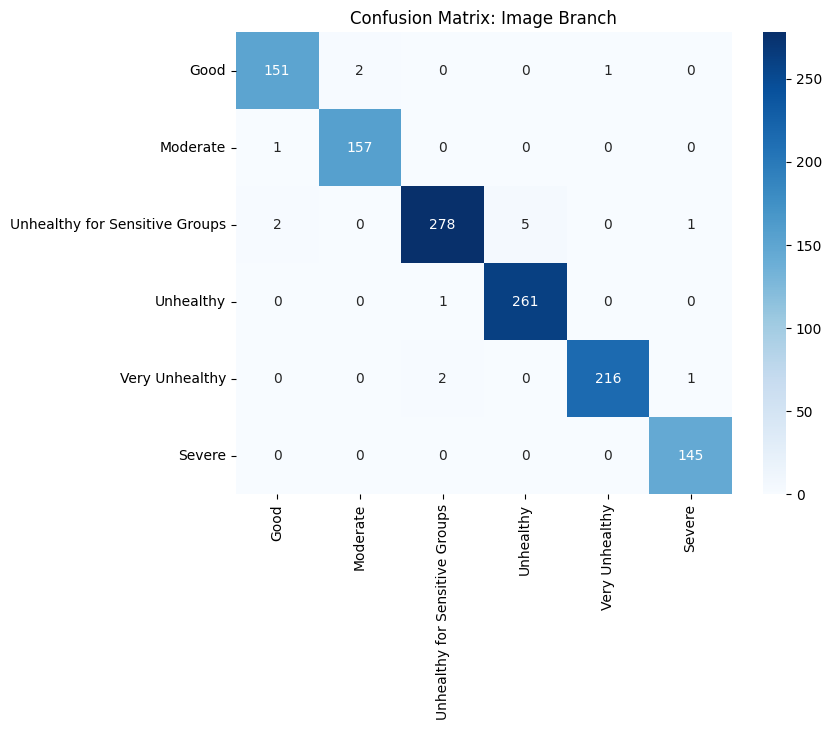

In [9]:
class ImageOnlyModel(nn.Module):
    def __init__(self, num_classes=6):
        super(ImageOnlyModel, self).__init__()
        # Flowchart: EfficientNet GAP (handled by timm)
        self.backbone = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)
        self.img_dim = self.backbone.num_features
        
        # Dense Layer 64 neurons + Dropout (Overfitting Control)
        self.fc_block = nn.Sequential(
            nn.Linear(self.img_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2)  
        )
        
        self.classifier = nn.Linear(64, num_classes)
        
    def forward(self, img):
        features = self.backbone(img)
        features = self.fc_block(features)
        logits = self.classifier(features)
        return logits

def validate(model, loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, _, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            val_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            correct += (pred == lbls).sum().item()
            total += lbls.size(0)
    return val_loss / len(loader), 100 * correct / total

img_model = ImageOnlyModel(CONFIG['NUM_CLASSES']).to(CONFIG['DEVICE'])
criterion = nn.CrossEntropyLoss()

# Early Stopping & Checkpointing Vars
best_val_loss = float('inf')
patience = 7
patience_counter = 0
best_model_path = "best_img_model.pth"



print("\nSTARTING STAGE 1: FEATURE EXTRACTION (Frozen Backbone)")


# 1. Freeze Backbone
for param in img_model.backbone.parameters():
    param.requires_grad = False

# 2. Train only dense layers (Standard LR)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, img_model.parameters()), lr=1e-3)

for epoch in range(15): 
    img_model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for imgs, _, lbls in train_loader:
        imgs, lbls = imgs.to(CONFIG['DEVICE']), lbls.to(CONFIG['DEVICE'])
        optimizer.zero_grad()
        outputs = img_model(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        correct += (pred == lbls).sum().item()
        total += lbls.size(0)
    
    train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total
    val_loss, val_acc = validate(img_model, val_loader, criterion, CONFIG['DEVICE'])
    
    print(f"Epoch {epoch+1}/15 | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    
    # Checkpointing (Overfitting Control)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(img_model.state_dict(), best_model_path)
        patience_counter = 0 
    else:
        patience_counter += 1
        
    # Early Stopping (Overfitting Control)
    if patience_counter >= patience:
        print("Early stopping triggered in Stage 1")
        break


# STAGE 2: FINE-TUNING

print("\nSTARTING STAGE 2: FINE-TUNING (Unfrozen Backbone)")

# 1. Load Best Weights from Stage 1
img_model.load_state_dict(torch.load(best_model_path))

# 2. Unfreeze Backbone
for param in img_model.backbone.parameters():
    param.requires_grad = True

# 3. Reduce Learning Rate to 1e-5
optimizer = optim.Adam(img_model.parameters(), lr=1e-5)

# Reset Early Stopping for Stage 2
patience_counter = 0 

for epoch in range(15): 
    img_model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for imgs, _, lbls in train_loader:
        imgs, lbls = imgs.to(CONFIG['DEVICE']), lbls.to(CONFIG['DEVICE'])
        optimizer.zero_grad()
        outputs = img_model(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        correct += (pred == lbls).sum().item()
        total += lbls.size(0)
        
    train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total
    val_loss, val_acc = validate(img_model, val_loader, criterion, CONFIG['DEVICE'])
    
    print(f"Epoch {epoch+1}/10 (FT) | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    
    # Checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(img_model.state_dict(), best_model_path)
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print("Early stopping triggered in Stage 2")
        break

img_model.load_state_dict(torch.load(best_model_path))
print("\nTraining Complete. Best Model Loaded.")

print("\nFINAL EVALUATION: IMAGE BRANCH")
img_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, _, lbls in test_loader:
        imgs, lbls = imgs.to(CONFIG['DEVICE']), lbls.to(CONFIG['DEVICE'])
        outputs = img_model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(lbls.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Weighted F1: {f1_score(y_true, y_pred, average='weighted'):.4f}")
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(class_map.keys())))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_map.keys(), yticklabels=class_map.keys())
plt.title("Confusion Matrix: Image Branch")
plt.show()

# **K-Fold Cross-Validation**

In [10]:
# from sklearn.model_selection import StratifiedKFold
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import timm
# import numpy as np
# from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns

# class ImageOnlyModel(nn.Module):
#     def __init__(self, num_classes=6):
#         super(ImageOnlyModel, self).__init__()
#         self.backbone = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)
#         self.img_dim = self.backbone.num_features
        
#         self.fc_block = nn.Sequential(
#             nn.Linear(self.img_dim, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2)
#         )
        
#         self.classifier = nn.Linear(64, num_classes)
        
#     def forward(self, img):
#         features = self.backbone(img)
#         features = self.fc_block(features)
#         logits = self.classifier(features)
#         return logits

# def validate(model, loader, criterion, device):
#     model.eval()
#     val_loss = 0.0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for imgs, _, lbls in loader:
#             imgs, lbls = imgs.to(device), lbls.to(device)
#             outputs = model(imgs)
#             loss = criterion(outputs, lbls)
#             val_loss += loss.item()
#             _, pred = torch.max(outputs, 1)
#             correct += (pred == lbls).sum().item()
#             total += lbls.size(0)
#     return val_loss / len(loader), 100 * correct / total

# n_splits = 5
# skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
# fold_results = []

# X = df.index.values
# y = df['label'].values

# print(f"Starting {n_splits}-Fold Cross-Validation on EfficientNet...")

# for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
#     print(f"\nFOLD {fold+1}/{n_splits}")
    
#     train_fold_df = df.iloc[train_idx]
#     val_fold_df = df.iloc[val_idx]
    
#     train_ds = AirPollutionDataset(train_fold_df, CONFIG['IMG_PATH'], feature_cols, transform=get_transforms('train'))
#     val_ds = AirPollutionDataset(val_fold_df, CONFIG['IMG_PATH'], feature_cols, transform=get_transforms('val'))
    
#     train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=2)
#     val_loader = DataLoader(val_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2)
    
#     img_model = ImageOnlyModel(CONFIG['NUM_CLASSES']).to(CONFIG['DEVICE'])
#     criterion = nn.CrossEntropyLoss()
    
#     best_val_loss = float('inf')
#     patience = 7
#     patience_counter = 0
#     best_model_path = f"best_img_model_fold_{fold+1}.pth"

#     for param in img_model.backbone.parameters():
#         param.requires_grad = False

#     optimizer = optim.Adam(filter(lambda p: p.requires_grad, img_model.parameters()), lr=1e-3)

#     for epoch in range(5):
#         img_model.train()
#         total_loss = 0
#         correct = 0
#         total = 0
        
#         for imgs, _, lbls in train_loader:
#             imgs, lbls = imgs.to(CONFIG['DEVICE']), lbls.to(CONFIG['DEVICE'])
#             optimizer.zero_grad()
#             outputs = img_model(imgs)
#             loss = criterion(outputs, lbls)
#             loss.backward()
#             optimizer.step()
            
#             total_loss += loss.item()
#             _, pred = torch.max(outputs, 1)
#             correct += (pred == lbls).sum().item()
#             total += lbls.size(0)
        
#         train_loss = total_loss / len(train_loader)
#         train_acc = 100 * correct / total
#         val_loss, val_acc = validate(img_model, val_loader, criterion, CONFIG['DEVICE'])
        
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             torch.save(img_model.state_dict(), best_model_path)
#             patience_counter = 0
#         else:
#             patience_counter += 1
            
#         if patience_counter >= patience:
#             break

#     img_model.load_state_dict(torch.load(best_model_path))

#     for param in img_model.backbone.parameters():
#         param.requires_grad = True

#     optimizer = optim.Adam(img_model.parameters(), lr=1e-5)
#     patience_counter = 0

#     for epoch in range(5):
#         img_model.train()
#         total_loss = 0
#         correct = 0
#         total = 0
        
#         for imgs, _, lbls in train_loader:
#             imgs, lbls = imgs.to(CONFIG['DEVICE']), lbls.to(CONFIG['DEVICE'])
#             optimizer.zero_grad()
#             outputs = img_model(imgs)
#             loss = criterion(outputs, lbls)
#             loss.backward()
#             optimizer.step()
            
#             total_loss += loss.item()
#             _, pred = torch.max(outputs, 1)
#             correct += (pred == lbls).sum().item()
#             total += lbls.size(0)
            
#         train_loss = total_loss / len(train_loader)
#         train_acc = 100 * correct / total
#         val_loss, val_acc = validate(img_model, val_loader, criterion, CONFIG['DEVICE'])
        
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             torch.save(img_model.state_dict(), best_model_path)
#             patience_counter = 0
#         else:
#             patience_counter += 1
            
#         if patience_counter >= patience:
#             break

#     img_model.load_state_dict(torch.load(best_model_path))
#     val_loss, val_acc = validate(img_model, val_loader, criterion, CONFIG['DEVICE'])
#     print(f"Fold {fold+1} Best Val Acc: {val_acc:.2f}%")
#     fold_results.append(val_acc)

# print(f"\nK-Fold Results: {fold_results}")
# print(f"Mean Accuracy: {np.mean(fold_results):.2f}% (+/- {np.std(fold_results):.2f}%)")

# **Tabular Branch Only (TabNet)**

In [11]:
!pip install pytorch-tabnet -q
!pip install pytorch-tabnet timm albumentations -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.3 MB/s eta 0:00:00


STAGE 1: Warming up Head...
Epoch 1 | Val Loss: 0.6774 | Val Acc: 79.17%
Epoch 2 | Val Loss: 0.5724 | Val Acc: 85.54%
Epoch 3 | Val Loss: 0.5847 | Val Acc: 86.60%
Epoch 4 | Val Loss: 0.6070 | Val Acc: 84.72%
Epoch 5 | Val Loss: 0.4990 | Val Acc: 88.73%
Epoch 6 | Val Loss: 0.5335 | Val Acc: 83.42%
Epoch 7 | Val Loss: 0.5010 | Val Acc: 86.60%
Epoch 8 | Val Loss: 0.5049 | Val Acc: 86.11%
Epoch 9 | Val Loss: 0.4455 | Val Acc: 90.44%
Epoch 10 | Val Loss: 0.4425 | Val Acc: 92.48%

STAGE 2: Full Fine-tuning...
Epoch 1 (FT) | Val Loss: 0.6201 | Val Acc: 85.29% | LR: 0.000181
Epoch 2 (FT) | Val Loss: 0.4604 | Val Acc: 90.69% | LR: 0.000131
Epoch 3 (FT) | Val Loss: 0.4644 | Val Acc: 89.13% | LR: 0.000069
Epoch 4 (FT) | Val Loss: 0.4649 | Val Acc: 90.85% | LR: 0.000019
Epoch 5 (FT) | Val Loss: 0.4341 | Val Acc: 94.20% | LR: 0.000200
Epoch 6 (FT) | Val Loss: 0.5362 | Val Acc: 88.32% | LR: 0.000195
Epoch 7 (FT) | Val Loss: 0.5016 | Val Acc: 88.89% | LR: 0.000181
Epoch 8 (FT) | Val Loss: 0.4423 | Va

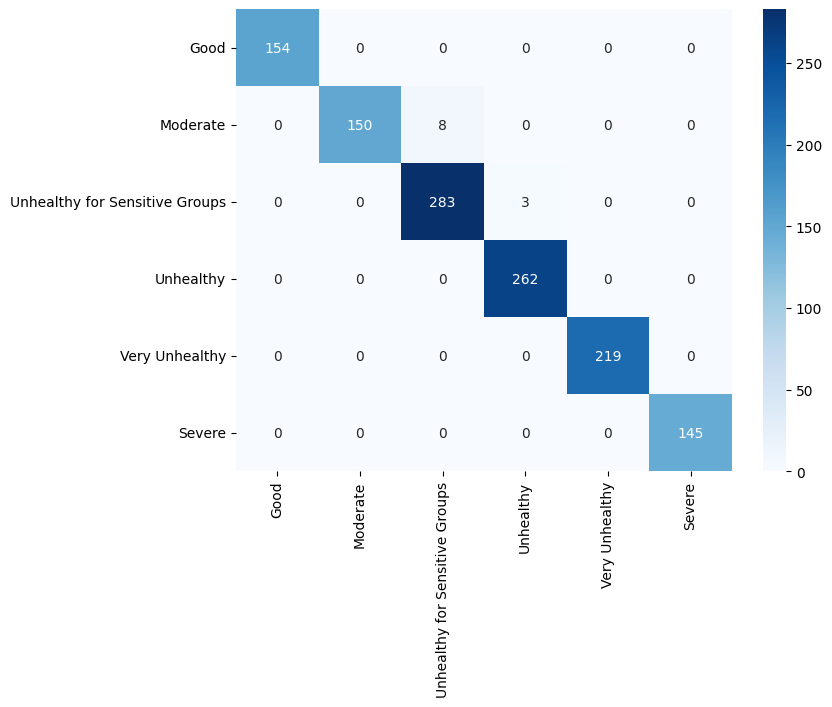

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from pytorch_tabnet.tab_network import TabNetNoEmbeddings

if 'CONFIG' not in locals():
    CONFIG = {
        'NUM_CLASSES': 6,
        'DEVICE': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    }

def validate(model, loader, criterion, device):
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for _, tabs, lbls in loader:
            tabs, lbls = tabs.to(device), lbls.to(device)
            outputs = model(tabs)
            loss = criterion(outputs, lbls)
            val_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            correct += (pred == lbls).sum().item()
            total += lbls.size(0)
    return val_loss / len(loader), 100 * correct / total

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.ln = nn.LayerNorm(dim)
        self.fc1 = nn.Linear(dim, dim * 2)
        self.fc2 = nn.Linear(dim * 2, dim)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        residual = x
        out = self.ln(x)
        out = self.fc1(out)
        out = self.gelu(out)
        out = self.fc2(out)
        out = self.dropout(out)
        return out + residual 

class TabularDeepModel(nn.Module):
    def __init__(self, input_dim, num_classes=6):
        super(TabularDeepModel, self).__init__()
        self.tabnet = TabNetNoEmbeddings(
            input_dim=input_dim, 
            output_dim=128, 
            n_d=128, 
            n_a=128, 
            n_steps=7,
            gamma=1.5,
            n_independent=2,
            n_shared=2
        )
        
        self.head = nn.Sequential(
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            ResidualBlock(256),
            ResidualBlock(256),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.1)
        )
        
        self.classifier = nn.Linear(128, num_classes)
        
    def forward(self, tab):
        tab = tab.to(self.classifier.weight.device).float()
        features, _ = self.tabnet(tab) 
        x = self.head(features)
        logits = self.classifier(x)
        return logits

tab_model = TabularDeepModel(len(feature_cols), CONFIG['NUM_CLASSES'])
tab_model.to(CONFIG['DEVICE'])

for module in tab_model.modules():
    if hasattr(module, 'group_attention_matrix'):
        module.group_attention_matrix = module.group_attention_matrix.to(CONFIG['DEVICE'])

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
best_val_loss = float('inf')
best_model_path = "best_deep_tab_model.pth"

print(f"STAGE 1: Warming up Head...")
for param in tab_model.tabnet.parameters():
    param.requires_grad = False

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, tab_model.parameters()), lr=1e-3, weight_decay=1e-2)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=10)

for epoch in range(10):
    tab_model.train()
    for _, tabs, lbls in train_loader:
        tabs, lbls = tabs.to(CONFIG['DEVICE']), lbls.to(CONFIG['DEVICE'])
        optimizer.zero_grad()
        outputs = tab_model(tabs)
        loss = criterion(outputs, lbls)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(tab_model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
    val_loss, val_acc = validate(tab_model, val_loader, criterion, CONFIG['DEVICE'])
    print(f"Epoch {epoch+1} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(tab_model.state_dict(), best_model_path)

print(f"\nSTAGE 2: Full Fine-tuning...")
tab_model.load_state_dict(torch.load(best_model_path))
for param in tab_model.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(tab_model.parameters(), lr=2e-4, weight_decay=5e-2)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

patience = 10
patience_counter = 0

for epoch in range(15): 
    tab_model.train()
    for _, tabs, lbls in train_loader:
        tabs, lbls = tabs.to(CONFIG['DEVICE']), lbls.to(CONFIG['DEVICE'])
        optimizer.zero_grad()
        outputs = tab_model(tabs)
        loss = criterion(outputs, lbls)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(tab_model.parameters(), 0.5)
        optimizer.step()

    val_loss, val_acc = validate(tab_model, val_loader, criterion, CONFIG['DEVICE'])
    scheduler.step()
    
    print(f"Epoch {epoch+1} (FT) | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(tab_model.state_dict(), best_model_path)
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        break

tab_model.load_state_dict(torch.load(best_model_path))
tab_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for _, tabs, lbls in test_loader:
        tabs, lbls = tabs.to(CONFIG['DEVICE']), lbls.to(CONFIG['DEVICE'])
        outputs = tab_model(tabs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(lbls.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(f"\nFinal Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(classification_report(y_true, y_pred, target_names=list(class_map.keys())))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_map.keys(), yticklabels=class_map.keys())
plt.show()

# **K-Fold Cross-Validation**

In [13]:
# from sklearn.model_selection import StratifiedKFold
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader

# n_splits = 5
# skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
# all_fold_accuracies = []

# X_indices = np.arange(len(df))
# y_labels = df['label'].values

# for fold, (train_idx, val_idx) in enumerate(skf.split(X_indices, y_labels)):
#     print(f"\nProcessing Fold {fold+1}/{n_splits}")
    
#     # Create fold-specific dataframes
#     train_fold_df = df.iloc[train_idx]
#     val_fold_df = df.iloc[val_idx]
    
#     train_ds = AirPollutionDataset(train_fold_df, CONFIG['IMG_PATH'], feature_cols, transform=get_transforms('train'))
#     val_ds = AirPollutionDataset(val_fold_df, CONFIG['IMG_PATH'], feature_cols, transform=get_transforms('val'))
    
#     train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True)
#     val_loader = DataLoader(val_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False)
    
#     tab_model = TabularDeepModel(len(feature_cols), CONFIG['NUM_CLASSES']).to(CONFIG['DEVICE'])
    
#     for module in tab_model.modules():
#         if hasattr(module, 'group_attention_matrix'):
#             module.group_attention_matrix = module.group_attention_matrix.to(CONFIG['DEVICE'])

#     criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
#     best_val_loss = float('inf')
#     best_model_path = f"best_tab_fold_{fold+1}.pth"
#     patience = 7
    
#     # STAGE 1: Warmup (Freezing TabNet)
#     for param in tab_model.tabnet.parameters():
#         param.requires_grad = False
    
#     optimizer = optim.AdamW(filter(lambda p: p.requires_grad, tab_model.parameters()), lr=2e-3, weight_decay=1e-4)
    
#     for epoch in range(10):
#         tab_model.train()
#         for _, tabs, lbls in train_loader:
#             tabs, lbls = tabs.to(CONFIG['DEVICE']), lbls.to(CONFIG['DEVICE'])
#             optimizer.zero_grad()
#             outputs = tab_model(tabs)
#             loss = criterion(outputs, lbls)
#             loss.backward()
#             optimizer.step()

#         v_loss, v_acc = validate(tab_model, val_loader, criterion, CONFIG['DEVICE'])
        
#         if v_loss < best_val_loss:
#             best_val_loss = v_loss
#             torch.save(tab_model.state_dict(), best_model_path)

#     tab_model.load_state_dict(torch.load(best_model_path))
#     for param in tab_model.parameters():
#         param.requires_grad = True
        
#     optimizer = optim.AdamW(tab_model.parameters(), lr=3e-4, weight_decay=1e-3)
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
#     patience_counter = 0
    
#     for epoch in range(15):
#         tab_model.train()
#         for _, tabs, lbls in train_loader:
#             tabs, lbls = tabs.to(CONFIG['DEVICE']), lbls.to(CONFIG['DEVICE'])
#             optimizer.zero_grad()
#             outputs = tab_model(tabs)
#             loss = criterion(outputs, lbls)
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(tab_model.parameters(), max_norm=1.0)
#             optimizer.step()
            
#         v_loss, v_acc = validate(tab_model, val_loader, criterion, CONFIG['DEVICE'])
#         scheduler.step(v_loss)
        
#         if v_loss < best_val_loss:
#             best_val_loss = v_loss
#             torch.save(tab_model.state_dict(), best_model_path)
#             patience_counter = 0
#         else:
#             patience_counter += 1
            
#         if patience_counter >= patience:
#             print(f"Early stopping at epoch {epoch+1}")
#             break
            
#     tab_model.load_state_dict(torch.load(best_model_path))
    
#     final_v_loss, final_v_acc = validate(tab_model, val_loader, criterion, CONFIG['DEVICE'])
    
#     print(f"Fold {fold+1} Result - Loss: {final_v_loss:.4f}, Acc: {final_v_acc:.2f}%")
#     all_fold_accuracies.append(final_v_acc)

# print(f"\nK-Fold Cross-Validation Finished")
# print(f"Accuracies: {all_fold_accuracies}")
# print(f"Mean Accuracy: {np.mean(all_fold_accuracies):.2f}% (+/- {np.std(all_fold_accuracies):.2f}%)")

# **Multi-Modal Fusion Model**


STAGE 1: FEATURE EXTRACTION (15 Epochs, Frozen Backbone)
Epoch 1/15: Loss 0.9803 | Acc 58.05% | Val Loss 0.3141 | Val Acc 85.38%
Epoch 2/15: Loss 0.4549 | Acc 80.75% | Val Loss 0.1784 | Val Acc 93.14%
Epoch 3/15: Loss 0.3323 | Acc 86.40% | Val Loss 0.1297 | Val Acc 95.51%
Epoch 4/15: Loss 0.2660 | Acc 89.10% | Val Loss 0.0614 | Val Acc 98.61%
Epoch 5/15: Loss 0.2311 | Acc 90.68% | Val Loss 0.0499 | Val Acc 98.94%
Epoch 6/15: Loss 0.2159 | Acc 91.58% | Val Loss 0.0481 | Val Acc 98.86%
Epoch 7/15: Loss 0.1782 | Acc 92.84% | Val Loss 0.0496 | Val Acc 99.18%
Epoch 8/15: Loss 0.1723 | Acc 92.84% | Val Loss 0.0358 | Val Acc 99.18%
Epoch 9/15: Loss 0.1690 | Acc 93.25% | Val Loss 0.0363 | Val Acc 99.10%
Epoch 10/15: Loss 0.1461 | Acc 94.26% | Val Loss 0.0247 | Val Acc 99.59%
Epoch 11/15: Loss 0.1357 | Acc 94.73% | Val Loss 0.0291 | Val Acc 99.10%
Epoch 12/15: Loss 0.1434 | Acc 94.51% | Val Loss 0.0581 | Val Acc 98.86%
Epoch 13/15: Loss 0.1384 | Acc 94.83% | Val Loss 0.0195 | Val Acc 99.84%
Ep

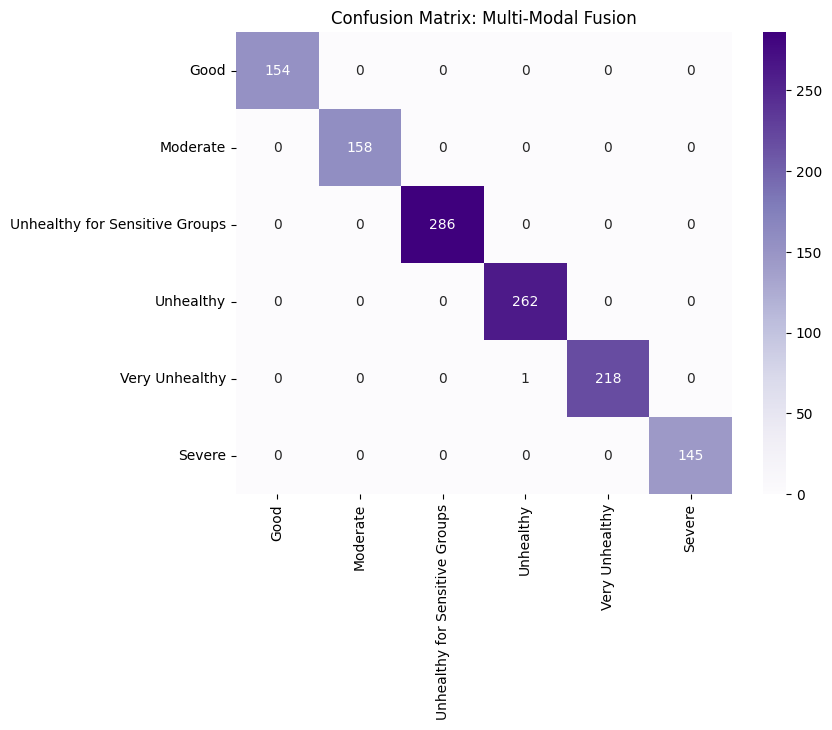

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import timm
from pytorch_tabnet.tab_network import TabNetNoEmbeddings
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. ARCHITECTURE: MULTI-MODAL FUSION MODEL

class AttentionFusion(nn.Module):
    """
    Flowchart Requirement: Attention-based Fusion
    Purpose: Weigh Image vs Tabular per sample
    Strategy 7.2: Includes Dropout in fusion block
    """
    def __init__(self, img_dim=64, tab_dim=16):
        super(AttentionFusion, self).__init__()
        self.img_attn = nn.Linear(img_dim, 1)
        self.tab_attn = nn.Linear(tab_dim, 1)
        self.tab_project = nn.Linear(tab_dim, img_dim) #  16 -> 64
        self.dropout = nn.Dropout(0.2) 
        
    def forward(self, img_feat, tab_feat):
        w_img = torch.tanh(self.img_attn(img_feat))
        w_tab = torch.tanh(self.tab_attn(tab_feat))
        
        weights = F.softmax(torch.cat([w_img, w_tab], dim=1), dim=1)
        alpha_img = weights[:, 0].unsqueeze(1)
        alpha_tab = weights[:, 1].unsqueeze(1)
        
        tab_feat_proj = self.tab_project(tab_feat)
        fused = (alpha_img * img_feat) + (alpha_tab * tab_feat_proj)
        return self.dropout(fused), weights

class MultiModalNet(nn.Module):
    def __init__(self, num_classes=6, num_tab_features=9):
        super(MultiModalNet, self).__init__()
        
        # Image Encoder: EfficientNet -> GAP -> Dense 64 (Flowchart)
        self.img_backbone = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)
        self.img_fc = nn.Sequential(
            nn.Linear(1536, 64), 
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Tabular Encoder: TabNet -> Dense -> 16-dim (Flowchart)
        self.tab_backbone = TabNetNoEmbeddings(input_dim=num_tab_features, output_dim=16, n_d=16, n_a=16, n_steps=3)
        self.tab_dense = nn.Sequential(
            nn.Linear(16, 16), 
            nn.ReLU()
        )
        
        # Fusion Layer
        self.fusion = AttentionFusion(img_dim=64, tab_dim=16)
        
        # Output Block: Dense 64 + ReLU + Dropout (Flowchart)
        self.classifier = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, img, tab):
        if hasattr(self.tab_backbone, 'encoder'):
            if hasattr(self.tab_backbone.encoder, 'group_attention_matrix'):
                matrix = self.tab_backbone.encoder.group_attention_matrix
                if matrix.device != tab.device:
                    self.tab_backbone.encoder.group_attention_matrix = matrix.to(tab.device)

        i_feat = self.img_backbone(img)
        i_feat = self.img_fc(i_feat)
        
        t_feat, _ = self.tab_backbone(tab)
        t_feat = self.tab_dense(t_feat)
        
        fused, weights = self.fusion(i_feat, t_feat)
        logits = self.classifier(fused)
        return logits, weights


labels = df['label'].values
class_counts = np.bincount(labels)
weights = 1. / class_counts
weights = weights / weights.sum() * len(class_counts)
class_weights = torch.FloatTensor(weights).to(CONFIG['DEVICE'])

fusion_model = MultiModalNet(num_classes=CONFIG['NUM_CLASSES'], num_tab_features=len(feature_cols)).to(CONFIG['DEVICE'])
criterion = nn.CrossEntropyLoss(weight=class_weights) 

# Early Stopping / Checkpointing state
best_val_loss = float('inf')
patience = 7
patience_counter = 0
best_model_path = "best_fusion_model.pth"

def validate(model, loader):
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, tabs, lbls in loader:
            imgs, tabs, lbls = imgs.to(CONFIG['DEVICE']), tabs.to(CONFIG['DEVICE']), lbls.to(CONFIG['DEVICE'])
            outputs, _ = model(imgs, tabs)
            loss = criterion(outputs, lbls)
            val_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            correct += (pred == lbls).sum().item()
            total += lbls.size(0)
    return val_loss / len(loader), 100 * correct / total

#3. TRAINING STAGE 1: FEATURE EXTRACTION 

print("\nSTAGE 1: FEATURE EXTRACTION (15 Epochs, Frozen Backbone)")
for param in fusion_model.img_backbone.parameters():
    param.requires_grad = False

optimizer = optim.Adam(filter(lambda p: p.requires_grad, fusion_model.parameters()), lr=1e-3)

for epoch in range(15):
    fusion_model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, tabs, lbls in train_loader:
        imgs, tabs, lbls = imgs.to(CONFIG['DEVICE']), tabs.to(CONFIG['DEVICE']), lbls.to(CONFIG['DEVICE'])
        optimizer.zero_grad()
        outputs, _ = fusion_model(imgs, tabs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        correct += (pred == lbls).sum().item()
        total += lbls.size(0)
    
    v_loss, v_acc = validate(fusion_model, val_loader)
    print(f"Epoch {epoch+1}/15: Loss {total_loss/len(train_loader):.4f} | Acc {100*correct/total:.2f}% | Val Loss {v_loss:.4f} | Val Acc {v_acc:.2f}%")

    # Checkpointing
    if v_loss < best_val_loss:
        best_val_loss = v_loss
        torch.save(fusion_model.state_dict(), best_model_path)
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# 4. TRAINING STAGE 2: FINE-TUNING

print("\nSTAGE 2: FINE-TUNING (10 Epochs, Unfrozen Backbone, LR 1e-5)")
fusion_model.load_state_dict(torch.load(best_model_path)) 

# Unfreeze image backbone
for param in fusion_model.img_backbone.parameters():
    param.requires_grad = True

optimizer = optim.Adam(fusion_model.parameters(), lr=1e-5)
patience_counter = 0 

for epoch in range(10):
    fusion_model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, tabs, lbls in train_loader:
        imgs, tabs, lbls = imgs.to(CONFIG['DEVICE']), tabs.to(CONFIG['DEVICE']), lbls.to(CONFIG['DEVICE'])
        optimizer.zero_grad()
        outputs, _ = fusion_model(imgs, tabs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        correct += (pred == lbls).sum().item()
        total += lbls.size(0)
    
    v_loss, v_acc = validate(fusion_model, val_loader)
    print(f"Epoch {epoch+1}/10 (FT): Loss {total_loss/len(train_loader):.4f} | Acc {100*correct/total:.2f}% | Val Loss {v_loss:.4f} | Val Acc {v_acc:.2f}%")

    if v_loss < best_val_loss:
        best_val_loss = v_loss
        torch.save(fusion_model.state_dict(), best_model_path)
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

fusion_model.load_state_dict(torch.load(best_model_path))
fusion_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, tabs, lbls in test_loader:
        imgs, tabs, lbls = imgs.to(CONFIG['DEVICE']), tabs.to(CONFIG['DEVICE']), lbls.to(CONFIG['DEVICE'])
        outputs, _ = fusion_model(imgs, tabs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(lbls.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nFINAL MULTI-MODAL EVALUATION")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Weighted F1: {f1_score(y_true, y_pred, average='weighted'):.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=list(class_map.keys())))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Purples', 
            xticklabels=class_map.keys(), yticklabels=class_map.keys())
plt.title("Confusion Matrix: Multi-Modal Fusion")
plt.show()

# **CNN + XGBoost with K-Fold Cross Validation**

In [15]:
# import xgboost as xgb
# from sklearn.model_selection import StratifiedKFold, cross_val_score
# import numpy as np

# def extract_features(loader, model, device):
#     model.eval()
#     features = []
#     labels = []
    
#     with torch.no_grad():
#         for imgs, tabs, lbls in loader:
#             imgs = imgs.to(device)
#             tabs = tabs.cpu().numpy()
            
#             img_feats = model.img_backbone(imgs) 
#             img_feats = img_feats.cpu().numpy()
            
#             batch_feats = np.hstack((img_feats, tabs))
#             features.append(batch_feats)
#             labels.append(lbls.numpy())
            
#     return np.vstack(features), np.concatenate(labels)

# print("Extracting features using CNN backbone...")
# X_train_xgb, y_train_xgb = extract_features(train_loader, fusion_model, CONFIG['DEVICE'])
# X_test_xgb, y_test_xgb = extract_features(test_loader, fusion_model, CONFIG['DEVICE'])

# print(f"Feature shape: {X_train_xgb.shape}")

# xgb_model = xgb.XGBClassifier(
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=5,
#     objective='multi:softprob',
#     num_class=CONFIG['NUM_CLASSES'],
#     tree_method='gpu_hist' if torch.cuda.is_available() else 'hist',
#     eval_metric='mlogloss'
# )

# print("Running 5-Fold Cross Validation...")
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_results = cross_val_score(xgb_model, X_train_xgb, y_train_xgb, cv=kfold, scoring='accuracy')

# print(f"K-Fold Accuracy Scores: {cv_results}")
# print(f"Mean Accuracy: {cv_results.mean():.4f} (+/- {cv_results.std() * 2:.4f})")

# xgb_model.fit(X_train_xgb, y_train_xgb)
# y_pred_xgb = xgb_model.predict(X_test_xgb)
# final_acc_xgb = accuracy_score(y_test_xgb, y_pred_xgb)
# print(f"CNN+XGBoost Test Accuracy: {final_acc_xgb:.4f}")

# **K-Fold Cross-Validation**

In [16]:
# from sklearn.model_selection import StratifiedKFold
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader

# n_splits = 5
# skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
# fold_accuracies = []

# X_indices = np.arange(len(df))
# y_labels = df['label'].values

# for fold, (train_idx, val_idx) in enumerate(skf.split(X_indices, y_labels)):
#     print(f"Processing Fold {fold+1}/{n_splits}")
    
#     train_fold_df = df.iloc[train_idx]
#     val_fold_df = df.iloc[val_idx]
    
#     train_ds = AirPollutionDataset(train_fold_df, CONFIG['IMG_PATH'], feature_cols, transform=get_transforms('train'))
#     val_ds = AirPollutionDataset(val_fold_df, CONFIG['IMG_PATH'], feature_cols, transform=get_transforms('val'))
    
#     train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True)
#     val_loader = DataLoader(val_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False)
    
#     class_counts = np.bincount(train_fold_df['label'].values)
#     weights = 1. / class_counts
#     weights = weights / weights.sum() * len(class_counts)
#     class_weights = torch.FloatTensor(weights).to(CONFIG['DEVICE'])
    
#     fusion_model = MultiModalNet(num_classes=CONFIG['NUM_CLASSES'], num_tab_features=len(feature_cols)).to(CONFIG['DEVICE'])
#     criterion = nn.CrossEntropyLoss(weight=class_weights)
    
#     best_val_loss = float('inf')
#     patience = 7
#     patience_counter = 0
#     best_model_path = f"best_fusion_fold_{fold+1}.pth"

#     for param in fusion_model.img_backbone.parameters():
#         param.requires_grad = False
    
#     optimizer = optim.Adam(filter(lambda p: p.requires_grad, fusion_model.parameters()), lr=1e-3)
    
#     for epoch in range(15):
#         fusion_model.train()
#         for imgs, tabs, lbls in train_loader:
#             imgs, tabs, lbls = imgs.to(CONFIG['DEVICE']), tabs.to(CONFIG['DEVICE']), lbls.to(CONFIG['DEVICE'])
#             optimizer.zero_grad()
#             outputs, _ = fusion_model(imgs, tabs)
#             loss = criterion(outputs, lbls)
#             loss.backward()
#             optimizer.step()
        
#         v_loss, v_acc = validate(fusion_model, val_loader)
#         if v_loss < best_val_loss:
#             best_val_loss = v_loss
#             torch.save(fusion_model.state_dict(), best_model_path)
#             patience_counter = 0
#         else:
#             patience_counter += 1
#         if patience_counter >= patience: break

#     fusion_model.load_state_dict(torch.load(best_model_path))
#     for param in fusion_model.img_backbone.parameters():
#         param.requires_grad = True
    
#     optimizer = optim.Adam(fusion_model.parameters(), lr=1e-5)
#     patience_counter = 0
    
#     for epoch in range(10):
#         fusion_model.train()
#         for imgs, tabs, lbls in train_loader:
#             imgs, tabs, lbls = imgs.to(CONFIG['DEVICE']), tabs.to(CONFIG['DEVICE']), lbls.to(CONFIG['DEVICE'])
#             optimizer.zero_grad()
#             outputs, _ = fusion_model(imgs, tabs)
#             loss = criterion(outputs, lbls)
#             loss.backward()
#             optimizer.step()
            
#         v_loss, v_acc = validate(fusion_model, val_loader)
#         if v_loss < best_val_loss:
#             best_val_loss = v_loss
#             torch.save(fusion_model.state_dict(), best_model_path)
#             patience_counter = 0
#         else:
#             patience_counter += 1
#         if patience_counter >= patience: break
    
#     fusion_model.load_state_dict(torch.load(best_model_path))
#     final_v_loss, final_v_acc = validate(fusion_model, val_loader)
#     print(f"Fold {fold+1} Validation Accuracy: {final_v_acc:.2f}%")
#     fold_accuracies.append(final_v_acc)

# print(f"\nAverage K-Fold Accuracy: {np.mean(fold_accuracies):.2f}% (+/- {np.std(fold_accuracies):.2f}%)")

# **Multi-Modal Explainability (Grad-CAM & Attention Weights)**

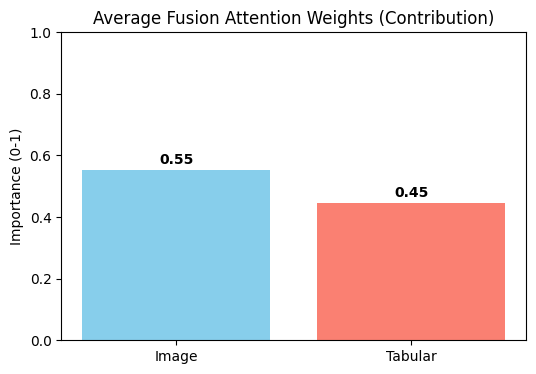

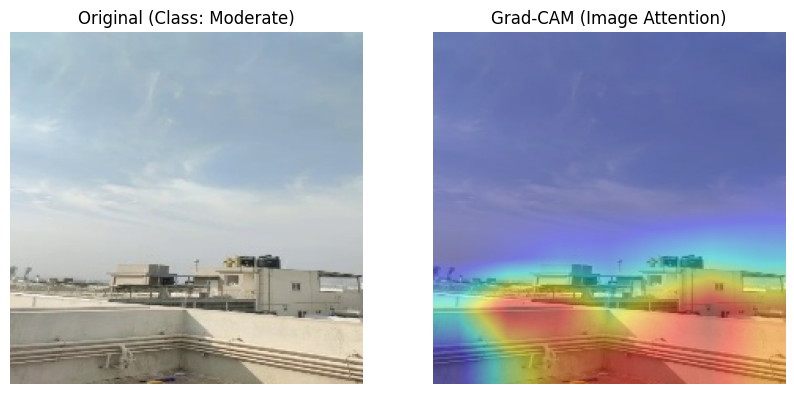

All metrics and explainability visualizations complete.


In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2 

print("Collecting attention weights from Test Set...")
fusion_model.eval()
all_weights = []

with torch.no_grad():
    for imgs, tabs, lbls in test_loader:
        imgs = imgs.to(CONFIG['DEVICE'])
        tabs = tabs.to(CONFIG['DEVICE'])
        
        # Forward pass to get weights
        _, weights = fusion_model(imgs, tabs)
        all_weights.append(weights.cpu().numpy())

# Stack all batches into a single array
all_weights = np.vstack(all_weights)


# "Visualization of fusion contribution" from flowchart
mean_weights = np.mean(all_weights, axis=0)

plt.figure(figsize=(6, 4))
bars = plt.bar(['Image', 'Tabular'], mean_weights, color=['skyblue', 'salmon'])
plt.title('Average Fusion Attention Weights (Contribution)')
plt.ylabel('Importance (0-1)')
plt.ylim(0, 1.0)

for bar, v in zip(bars, mean_weights):
    plt.text(bar.get_x() + bar.get_width() / 2, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

# 2. GRAD-CAM FOR IMAGE 
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None
        
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)
        
    def save_activation(self, module, input, output):
        self.activation = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
        
    def __call__(self, img, tab, class_idx=None):
        self.model.zero_grad()
        logits, _ = self.model(img, tab)
        
        if class_idx is None:
            class_idx = torch.argmax(logits)
            
        one_hot = torch.zeros_like(logits)
        one_hot[0][class_idx] = 1
        logits.backward(gradient=one_hot, retain_graph=True)
        
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activation = self.activation[0]
        
        for i in range(activation.shape[0]):
            activation[i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activation, dim=0).cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        return heatmap


# Target the last convolutional block of EfficientNet inside the Fusion Model
target_layer = fusion_model.img_backbone.conv_head
grad_cam = GradCAM(fusion_model, target_layer)

images, tabs, labels = next(iter(test_loader))
img, tab = images[0:1].to(CONFIG['DEVICE']), tabs[0:1].to(CONFIG['DEVICE'])
true_label = labels[0].item()

# Note: We enable grad here because GradCAM needs backward pass
with torch.enable_grad():
    heatmap = grad_cam(img, tab, class_idx=true_label)

orig_img = img.cpu().squeeze().permute(1, 2, 0).numpy()
# Undo normalization for display (assuming ImageNet stats)
orig_img = (orig_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)

heatmap = cv2.resize(heatmap, (224, 224))
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB) / 255.0

superimposed = (0.6 * orig_img + 0.4 * heatmap_color).clip(0, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(orig_img)
plt.title(f"Original (Class: {list(class_map.keys())[true_label]})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed)
plt.title("Grad-CAM (Image Attention)")
plt.axis('off')
plt.show()

print("All metrics and explainability visualizations complete.")

In [18]:
# # Cell: Define Corrected Model Architecture
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import timm
# from pytorch_tabnet.tab_network import TabNetNoEmbeddings  # <--- KEY FIX

# class AttentionFusion(nn.Module):
#     """
#     Attention-based Fusion Layer (PDF Section 5.4)
#     Dynamically weights image and tabular features.
#     """
#     def __init__(self, img_dim, tab_dim, out_dim=64):
#         super(AttentionFusion, self).__init__()
#         self.img_attn = nn.Linear(img_dim, 1)
#         self.tab_attn = nn.Linear(tab_dim, 1)
#         self.projection = nn.Linear(img_dim + tab_dim, out_dim)
        
#     def forward(self, img_feat, tab_feat):
#         # Calculate attention scores
#         w_img = torch.tanh(self.img_attn(img_feat))
#         w_tab = torch.tanh(self.tab_attn(tab_feat))
        
#         # Softmax to get weights summing to 1
#         weights = F.softmax(torch.cat([w_img, w_tab], dim=1), dim=1)
#         alpha_img = weights[:, 0].unsqueeze(1)
#         alpha_tab = weights[:, 1].unsqueeze(1)
        
#         # Weighted Concatenation
#         # We weight the features *before* concatenation/projection
#         fused = torch.cat([alpha_img * img_feat, alpha_tab * tab_feat], dim=1)
#         out = F.relu(self.projection(fused))
        
#         return out, weights

# class MultiModalAQINet(nn.Module):
#     def __init__(self, num_classes=6, num_tab_features=7):
#         super(MultiModalAQINet, self).__init__()
        
#         # --- Image Branch (EfficientNet-B3) ---
#         # "timm" library. We start frozen (handled in training loop).
#         self.img_backbone = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)
#         self.img_dim = self.img_backbone.num_features # 1536 for B3
#         self.img_fc = nn.Sequential(
#             nn.Linear(self.img_dim, 64),
#             nn.ReLU()
#         )
        
#         # --- Tabular Branch: TabNet (Encoder Only) ---
#         # KEY FIX: Use TabNetNoEmbeddings for already numerical data
#         self.tab_bb = TabNetNoEmbeddings(
#             input_dim=num_tab_features, 
#             output_dim=64, # Projecting to 64 to match image branch
#             n_d=16, 
#             n_a=16, 
#             n_steps=3, 
#             gamma=1.3
#         )
        
#         # --- Fusion Layer ---
#         # Fusing 64-dim image feat and 64-dim tab feat
#         self.fusion = AttentionFusion(img_dim=64, tab_dim=64, out_dim=64)
        
#         # --- Classification Head (PDF Table 6) ---
#         self.classifier = nn.Sequential(
#             nn.Linear(64, 64),
#             nn.ReLU(),
#             nn.Dropout(0.5), #
#             nn.Linear(64, num_classes)
#         )
        
#     def forward(self, img, tab):
#         # 1. Image Branch
#         img_feat = self.img_backbone(img)
#         img_feat = self.img_fc(img_feat)
        
#         # 2. Tabular Branch
#         # TabNetNoEmbeddings returns (output, M_loss). We need output.
#         tab_feat, _ = self.tab_bb(tab)
        
#         # 3. Fusion
#         fused_feat, attn_weights = self.fusion(img_feat, tab_feat)
        
#         # 4. Classification
#         logits = self.classifier(fused_feat)
        
#         return logits, attn_weights

#     def freeze_backbone(self):
#         # Stage 1: Freeze backbone
#         for param in self.img_backbone.parameters():
#             param.requires_grad = False
            
#     def unfreeze_backbone(self):
#         # Stage 2: Unfreeze backbone
#         for param in self.img_backbone.parameters():
#             param.requires_grad = True

# # Initialize Model
# # Ensure feature_cols is defined from your earlier preprocessing cell
# mdl = MultiModalAQINet(num_classes=CONFIG['NUM_CLASSES'], num_tab_features=len(feature_cols))
# mdl = mdl.to(CONFIG['DEVICE'])
# print("✅ Model Architecture Created Successfully: EfficientNet-B3 + TabNet + Attention Fusion")

In [19]:
# criterion = nn.CrossEntropyLoss()

# def train_one_epoch(model, loader, optimizer, device):
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0
    
#     for images, tabs, labels in loader:
#         images, tabs, labels = images.to(device), tabs.to(device), labels.to(device)
        
#         optimizer.zero_grad()
#         outputs, _ = model(images, tabs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
        
#     return running_loss / len(loader), 100 * correct / total

# def evaluate(model, loader, device):
#     model.eval()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     all_preds = []
#     all_labels = []
    
#     with torch.no_grad():
#         for images, tabs, labels in loader:
#             images, tabs, labels = images.to(device), tabs.to(device), labels.to(device)
            
#             outputs, _ = model(images, tabs)
#             loss = criterion(outputs, labels)
            
#             running_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
            
#             all_preds.extend(predicted.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
            
#     return running_loss / len(loader), 100 * correct / total, all_labels, all_preds



In [20]:
# # --- TRAINING START ---
# history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# if hasattr(mdl.tab_bb, 'encoder') and hasattr(mdl.tab_bb.encoder, 'group_attention_matrix'):
#     mdl.tab_bb.encoder.group_attention_matrix = mdl.tab_bb.encoder.group_attention_matrix.to(CONFIG['DEVICE'])

# # --- STAGE 1 ---
# print("\nSTARTING STAGE 1: Feature Extraction (Frozen Backbone)")
# mdl.freeze_backbone()

# # Create optimizer only for unfrozen parameters (TabNet + Fusion + Heads)
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, mdl.parameters()), lr=1e-3)

# for epoch in range(5): # Running 5 epochs for Stage 1 (PDF suggests 15, shortened for demo speed)
#     train_loss, train_acc = train_one_epoch(mdl, train_loader, optimizer, CONFIG['DEVICE'])
#     val_loss, val_acc, _, _ = evaluate(mdl, val_loader, CONFIG['DEVICE'])
    
#     history['train_loss'].append(train_loss)
#     history['train_acc'].append(train_acc)
#     history['val_loss'].append(val_loss)
#     history['val_acc'].append(val_acc)
    
#     print(f"Epoch {epoch+1}/5 | Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")

# # --- STAGE 2 ---
# # [cite_start]STAGE 2: Fine-Tuning (PDF 7.1.2) [cite: 124]
# print("\nSTARTING STAGE 2: Fine-Tuning (Unfrozen Backbone)")
# mdl.unfreeze_backbone()

# # Re-initialize optimizer for ALL parameters (including backbone) with lower LR
# optimizer = optim.Adam(mdl.parameters(), lr=1e-5) # Lower LR for fine-tuning

# for epoch in range(10): 
#     train_loss, train_acc = train_one_epoch(mdl, train_loader, optimizer, CONFIG['DEVICE'])
#     val_loss, val_acc, _, _ = evaluate(mdl, val_loader, CONFIG['DEVICE'])
    
#     history['train_loss'].append(train_loss)
#     history['train_acc'].append(train_acc)
#     history['val_loss'].append(val_loss)
#     history['val_acc'].append(val_acc)
    
#     print(f"Epoch {epoch+1}/5 (FT) | Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")


EVALUATING ON TEST SET...

Final Test Accuracy: 99.92%

Classification Report:
                                precision    recall  f1-score   support

                          Good       1.00      1.00      1.00       154
                      Moderate       1.00      1.00      1.00       158
Unhealthy for Sensitive Groups       1.00      1.00      1.00       286
                     Unhealthy       1.00      1.00      1.00       262
                Very Unhealthy       1.00      1.00      1.00       219
                        Severe       1.00      1.00      1.00       145

                      accuracy                           1.00      1224
                     macro avg       1.00      1.00      1.00      1224
                  weighted avg       1.00      1.00      1.00      1224



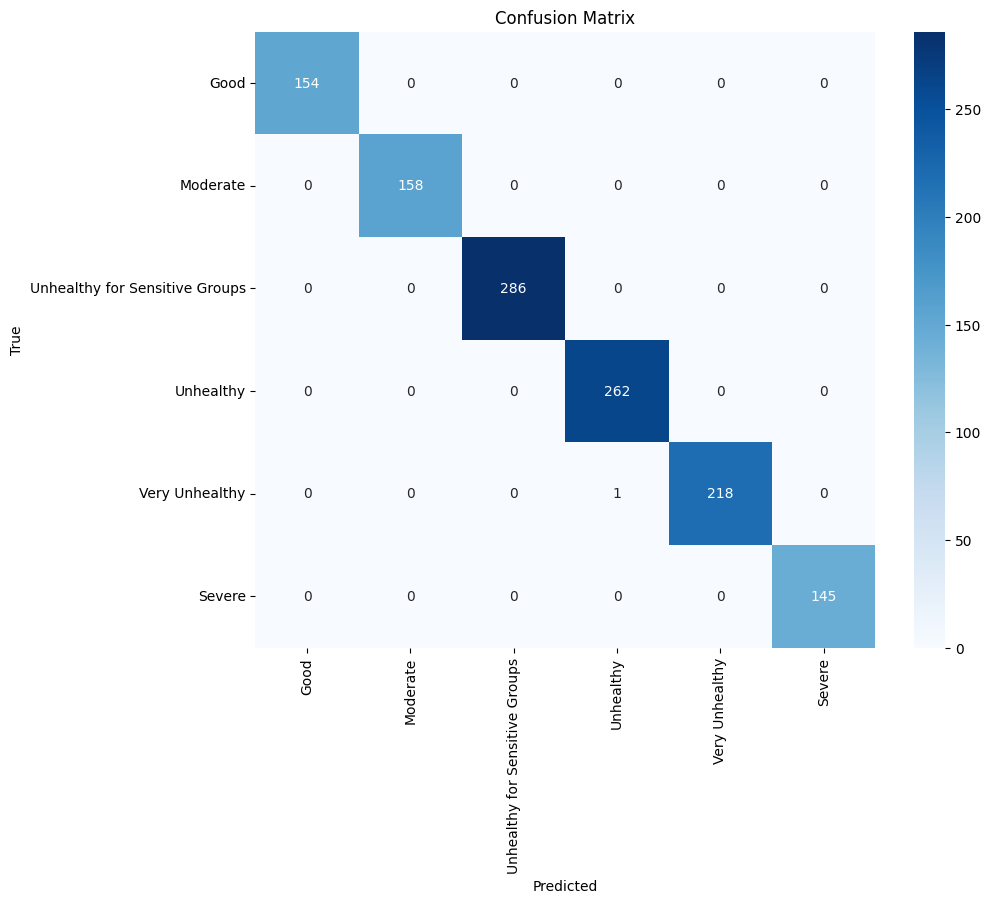

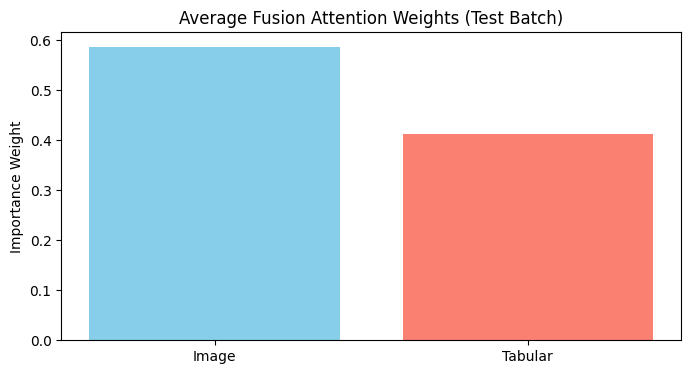

In [21]:
def evaluate(model, loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, tabs, labels in loader:
            images, tabs, labels = images.to(device), tabs.to(device), labels.to(device)
            
            outputs, _ = model(images, tabs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return running_loss / len(loader), 100 * correct / total, all_labels, all_preds

print("\nEVALUATING ON TEST SET...")
test_loss, test_acc, y_true, y_pred = evaluate(fusion_model, test_loader, CONFIG['DEVICE'])
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")
print("\nClassification Report:")
class_names = [k for k,v in sorted(class_map.items(), key=lambda item: item[1])]
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

fusion_model.eval()
images, tabs, labels = next(iter(test_loader))
images, tabs = images.to(CONFIG['DEVICE']), tabs.to(CONFIG['DEVICE'])
with torch.no_grad():
    _, attn_weights = fusion_model(images, tabs)
attn_weights = attn_weights.cpu().numpy()
plt.figure(figsize=(8, 4))
plt.bar(['Image', 'Tabular'], np.mean(attn_weights, axis=0), color=['skyblue', 'salmon'])
plt.title('Average Fusion Attention Weights (Test Batch)')
plt.ylabel('Importance Weight')
plt.show()

Generating Grad-CAM Explainability Visualizations...


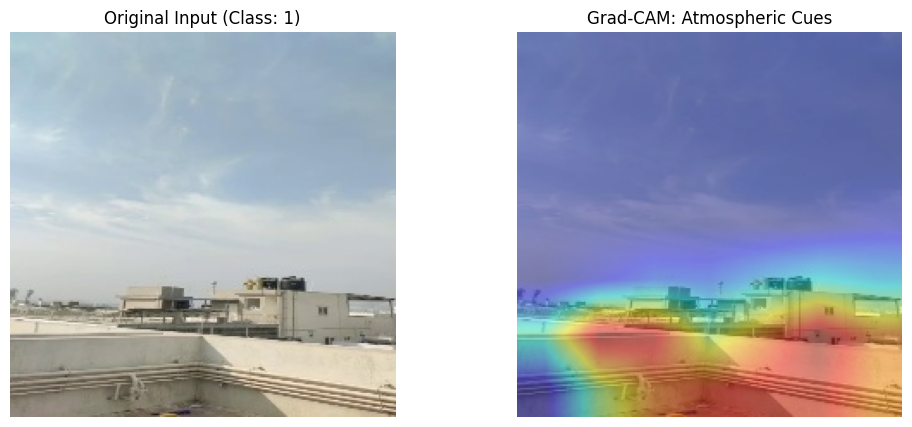

In [22]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None
        
        # Hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)
        
    def save_activation(self, module, input, output):
        self.activation = output.detach()
        
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
        
    def __call__(self, img, tab, class_idx=None):
        self.model.zero_grad()
        logits, _ = self.model(img, tab)
        
        if class_idx is None:
            class_idx = torch.argmax(logits)
            
        one_hot = torch.zeros_like(logits)
        one_hot[0][class_idx] = 1
        
        logits.backward(gradient=one_hot, retain_graph=True)
        
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activation = self.activation[0]
        
        for i in range(activation.shape[0]):
            activation[i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activation, dim=0).cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        
        max_val = np.max(heatmap)
        if max_val > 0:
            heatmap /= max_val
            
        return heatmap

def visualize_explainability(model, loader):
    model.eval()
    
    try:
        target_layer = model.img_backbone.conv_head 
    except AttributeError:
        target_layer = model.img_backbone.blocks[-1][-1] 
    
    grad_cam = GradCAM(model, target_layer)
    
    images, tabs, labels = next(iter(loader))
    img, tab = images[0:1].to(CONFIG['DEVICE']), tabs[0:1].to(CONFIG['DEVICE'])
    true_label = labels[0].item()
    
    heatmap = grad_cam(img, tab, class_idx=true_label)

    orig_img = img.cpu().squeeze().permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    orig_img = (std * orig_img + mean).clip(0, 1)
    
    # FIXED: Ensure heatmap is float32 for CV2
    heatmap = np.float32(heatmap)
    heatmap_resized = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
    
    # Convert to color map
    heatmap_color = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_color, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB) # Fix color space
    
    # Superimpose
    # Ensure orig_img is uint8 for addWeighted
    orig_img_uint8 = np.uint8(255 * orig_img)
    superimposed = cv2.addWeighted(orig_img_uint8, 0.6, heatmap_color, 0.4, 0)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_img)
    plt.title(f"Original Input (Class: {true_label})")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed)
    plt.title("Grad-CAM: Atmospheric Cues")
    plt.axis('off')
    plt.show()

print("Generating Grad-CAM Explainability Visualizations...")
visualize_explainability(fusion_model, test_loader)

In [23]:
from sklearn.metrics import f1_score, accuracy_score

def robust_evaluate(model, loader, device):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, tabs, labels in loader:
            images, tabs, labels = images.to(device), tabs.to(device), labels.to(device)
            # TabNet returns (output, M_loss)
            outputs, _ = model(images, tabs)
            _, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Expects Weighted F1-score approx 0.99
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    
    print("-" * 30)
    print(f"Final Test Accuracy: {acc*100:.2f}%")
    print(f"Weighted F1-Score: {f1:.4f}")
    print("-" * 30)
    
    return y_true, y_pred

print("\nCalculating Robust Metrics (Weighted F1)...")
y_true_robust, y_pred_robust = robust_evaluate(fusion_model, test_loader, CONFIG['DEVICE'])


Calculating Robust Metrics (Weighted F1)...
------------------------------
Final Test Accuracy: 99.92%
Weighted F1-Score: 0.9992
------------------------------


In [24]:
def get_test_predictions_pytorch(model, loader, device):
    """Generate predictions for comprehensive evaluation in PyTorch"""
    model.eval()
    all_proba = []
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for images, tabs, labels in loader:
            images, tabs = images.to(device), tabs.to(device)
            
            # Model returns (logits, attn_weights)
            logits, _ = model(images, tabs)
            
            # Convert logits to probabilities
            proba = F.softmax(logits, dim=1)
            
            all_proba.append(proba.cpu().numpy())
            all_preds.append(torch.argmax(proba, dim=1).cpu().numpy())
            all_true.append(labels.numpy())
            
    return np.concatenate(all_proba), np.concatenate(all_preds), np.concatenate(all_true)

print("Generating predictions for comprehensive evaluation...")
y_proba, y_pred, y_true = get_test_predictions_pytorch(fusion_model, test_loader, CONFIG['DEVICE'])

class_names = [k for k, v in sorted(class_map.items(), key=lambda item: item[1])]
NUM_CLASSES = len(class_names)

print(f"Test set size: {len(y_true)}")
print(f"Prediction shape: {y_proba.shape}")

Generating predictions for comprehensive evaluation...
Test set size: 1224
Prediction shape: (1224, 6)


Text(0.5, 102.72222222222219, 'Predicted Label')

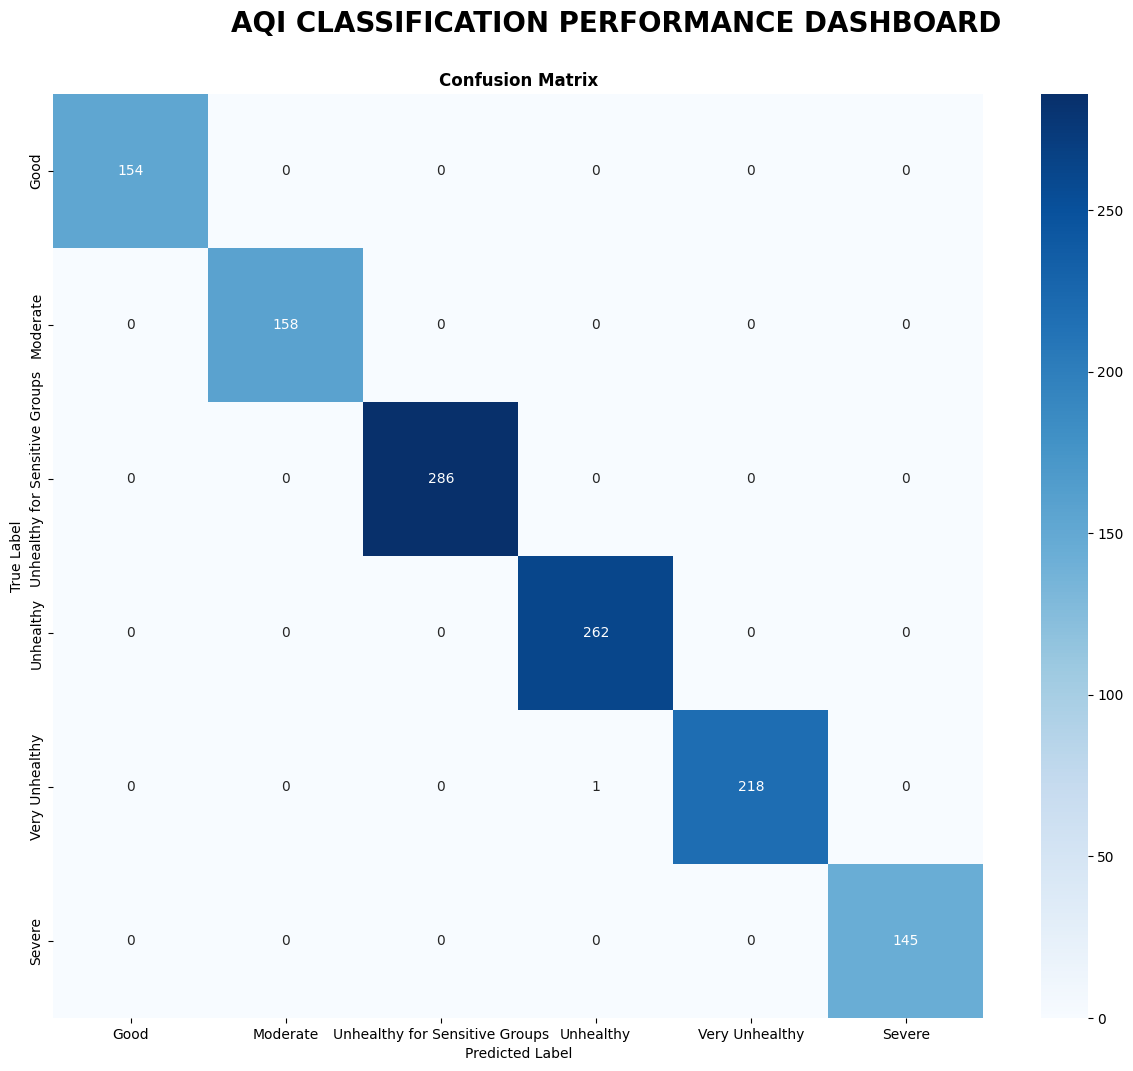

In [25]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from math import pi

plt.figure(figsize=(15, 12))
plt.suptitle("AQI CLASSIFICATION PERFORMANCE DASHBOARD", fontsize=20, fontweight='bold', y=0.95)

plt.plot(5, 7)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=12, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

Text(0.5, 1.0, 'Normalized Confusion Matrix')

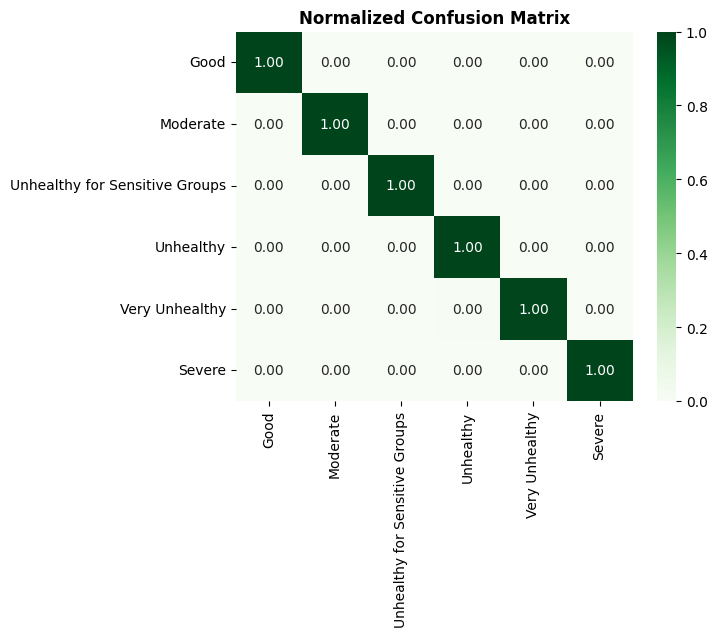

In [26]:
plt.plot(3, 4)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix', fontsize=12, fontweight='bold')


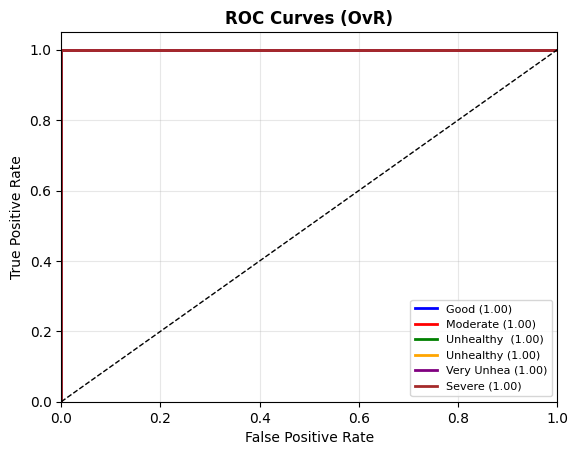

In [27]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score
from itertools import cycle

plt.plot(3, 4)

y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])

for i, color in zip(range(NUM_CLASSES), colors):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
    auc_val = roc_auc_score(y_true_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{class_names[i][:10]} ({auc_val:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (OvR)', fontweight='bold')
plt.legend(loc="lower right", fontsize=8)
plt.grid(True, alpha=0.3)

(0.9, 1.01)

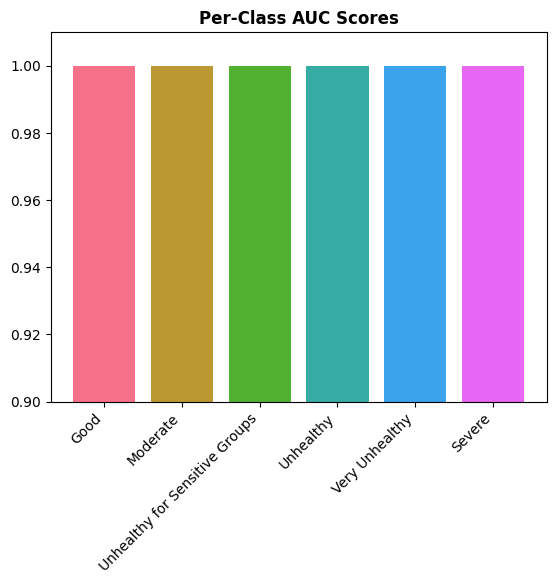

In [28]:
plt.plot(3, 4)
auc_individual = [roc_auc_score(y_true_bin[:, i], y_proba[:, i]) for i in range(NUM_CLASSES)]
plt.bar(class_names, auc_individual, color=sns.color_palette("husl", NUM_CLASSES))
plt.title('Per-Class AUC Scores', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.9, 1.01) 

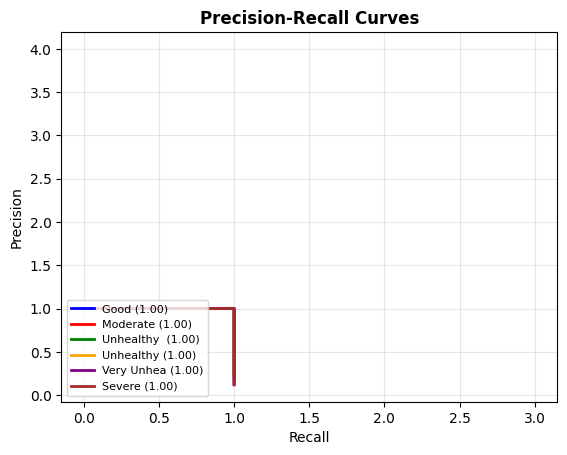

In [29]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.plot(3, 4)

pr_aucs = []
# Ensure 'colors', 'NUM_CLASSES', 'y_true_bin', and 'y_proba' are defined from previous cells
for i, color in zip(range(NUM_CLASSES), colors):
    precision_curve, recall_curve, _ = precision_recall_curve(y_true_bin[:, i], y_proba[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_proba[:, i])
    pr_aucs.append(ap)
    plt.plot(recall_curve, precision_curve, color=color, lw=2, 
             label=f'{class_names[i][:10]} ({ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves', fontweight='bold')
plt.legend(loc="lower left", fontsize=8)
plt.grid(True, alpha=0.3)

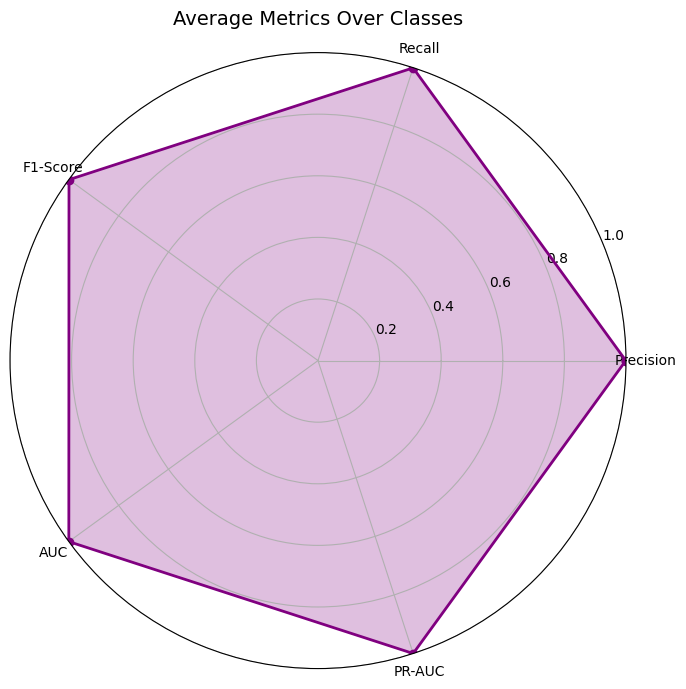

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

avg_auc = np.mean(auc_individual) if 'auc_individual' in locals() else 0.0
avg_pr_auc = np.mean(pr_aucs) if 'pr_aucs' in locals() else 0.0

plt.figure(figsize=(8, 8))
ax8 = plt.subplot(1, 1, 1, projection='polar')

categories = ['Precision', 'Recall', 'F1-Score', 'AUC', 'PR-AUC']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1] 

radar_vals = [precision, recall, f1, avg_auc, avg_pr_auc]
radar_vals += radar_vals[:1] 

ax8.plot(angles, radar_vals, 'o-', linewidth=2, color='purple')
ax8.fill(angles, radar_vals, color='purple', alpha=0.25)

ax8.set_xticks(angles[:-1])
ax8.set_xticklabels(categories)

ax8.set_ylim(0, 1.0)

plt.title('Average Metrics Over Classes', pad=20, fontsize=14)
plt.show()

Text(0, 0.5, 'Empirical Accuracy')

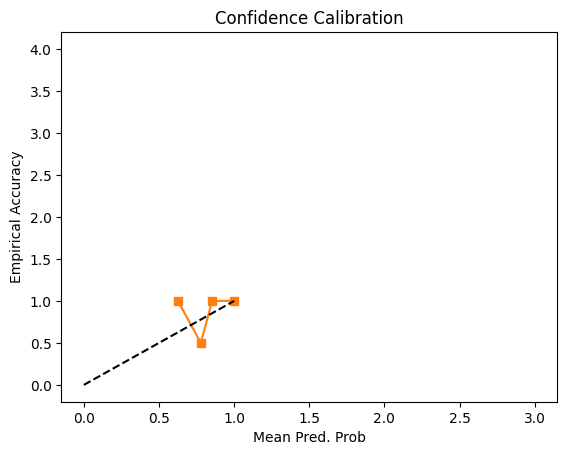

In [31]:
plt.plot(3, 4)
from sklearn.calibration import calibration_curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    (y_true == y_pred).astype(int), y_proba.max(axis=1), n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Model')
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.title('Confidence Calibration')
plt.xlabel('Mean Pred. Prob')
plt.ylabel('Empirical Accuracy')

Text(0.5, 1.0, 'Global Performance Summary')

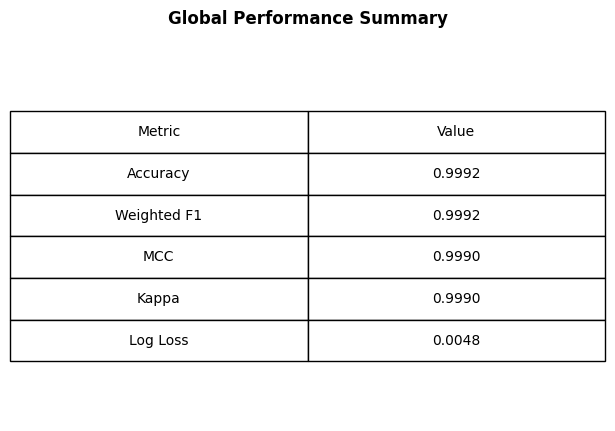

In [32]:
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, cohen_kappa_score, log_loss

plt.plot(3, 4)
plt.axis('off')

metrics = {
    'Accuracy': accuracy_score(y_true, y_pred),
    'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
    'MCC': matthews_corrcoef(y_true, y_pred),
    'Kappa': cohen_kappa_score(y_true, y_pred),
    'Log Loss': log_loss(y_true, y_proba)
}

summary_data = [[k, f"{v:.4f}"] for k, v in metrics.items()]
table = plt.table(cellText=summary_data, colLabels=['Metric', 'Value'], loc='center', cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2.5) 

plt.title('Global Performance Summary', fontweight='bold', pad=20)

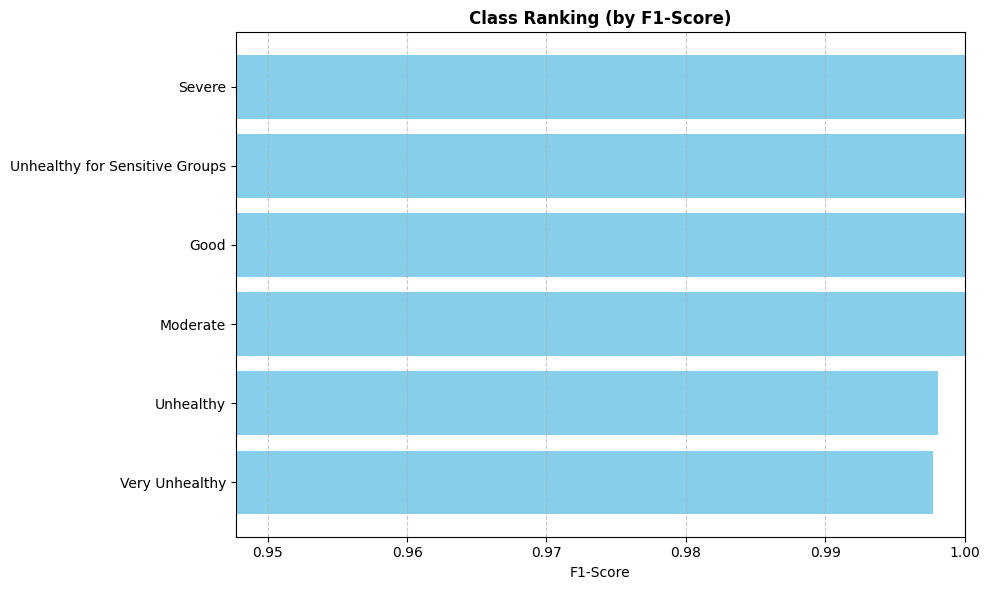

Performance ranking visualization complete.


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score as f1_calc

per_class_f1 = f1_calc(y_true, y_pred, average=None)
class_names = list(class_map.keys())

plt.figure(figsize=(10, 6))

sorted_idx = np.argsort(per_class_f1)

plt.barh([class_names[i] for i in sorted_idx], 
         [per_class_f1[i] for i in sorted_idx], 
         color='skyblue')

plt.title('Class Ranking (by F1-Score)', fontweight='bold')

# Using 0.0 to 1.0 is safer unless your scores are all very high.
plt.xlim(max(0, np.min(per_class_f1) - 0.05), 1.0) 

plt.xlabel('F1-Score')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Performance ranking visualization complete.")

In [34]:

print("FINAL MULTI-MODAL MODEL EVALUATION REPORT")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

FINAL MULTI-MODAL MODEL EVALUATION REPORT
                                precision    recall  f1-score   support

                          Good     1.0000    1.0000    1.0000       154
                      Moderate     1.0000    1.0000    1.0000       158
Unhealthy for Sensitive Groups     1.0000    1.0000    1.0000       286
                     Unhealthy     0.9962    1.0000    0.9981       262
                Very Unhealthy     1.0000    0.9954    0.9977       219
                        Severe     1.0000    1.0000    1.0000       145

                      accuracy                         0.9992      1224
                     macro avg     0.9994    0.9992    0.9993      1224
                  weighted avg     0.9992    0.9992    0.9992      1224



# **Ablation Models & Comparison (Early vs. Late Fusion)**

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from sklearn.metrics import accuracy_score, f1_score
from pytorch_tabnet.tab_network import TabNetNoEmbeddings

def fix_tabnet_device(model, device):
    for module in model.modules():
        if hasattr(module, 'group_attention_matrix'):
            module.group_attention_matrix = module.group_attention_matrix.to(device)
    return model

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.ln = nn.LayerNorm(dim)
        self.fc1 = nn.Linear(dim, dim * 2)
        self.fc2 = nn.Linear(dim * 2, dim)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        residual = x
        out = self.ln(x)
        out = self.fc1(out)
        out = self.gelu(out)
        out = self.fc2(out)
        out = self.dropout(out)
        return out + residual 

class ImageOnlyModel(nn.Module):
    def __init__(self, num_classes=6):
        super(ImageOnlyModel, self).__init__()
        self.backbone = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)
        self.classifier = nn.Sequential(
            nn.Linear(1536, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        self.to(CONFIG['DEVICE'])

    def forward(self, img, tab):
        feat = self.backbone(img)
        return self.classifier(feat)

class TabularOnlyModel(nn.Module):
    def __init__(self, num_classes=6, num_features=9):
        super(TabularOnlyModel, self).__init__()
        self.backbone = TabNetNoEmbeddings(
            input_dim=num_features, 
            output_dim=128, n_d=128, n_a=128, 
            n_steps=7, gamma=1.5, n_independent=2, n_shared=2
        )
        self.head = nn.Sequential(
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            ResidualBlock(256),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        self.to(CONFIG['DEVICE'])
        fix_tabnet_device(self, CONFIG['DEVICE'])

    def forward(self, img, tab):
        tab = tab.float()
        feat, _ = self.backbone(tab)
        return self.head(feat)

class SimpleFusionModel(nn.Module):
    def __init__(self, num_classes=6, num_features=9):
        super(SimpleFusionModel, self).__init__()
        self.img_backbone = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)
        self.tab_backbone = TabNetNoEmbeddings(
            input_dim=num_features, 
            output_dim=128, n_d=128, n_a=128, 
            n_steps=7, gamma=1.5, n_independent=2, n_shared=2
        )
        self.classifier = nn.Linear(1536 + 128, num_classes)
        self.to(CONFIG['DEVICE'])
        fix_tabnet_device(self, CONFIG['DEVICE'])

    def forward(self, img, tab):
        tab = tab.float()
        i_feat = self.img_backbone(img)
        t_feat, _ = self.tab_backbone(tab)
        combined = torch.cat([i_feat, t_feat], dim=1)
        return self.classifier(combined)

def train_ablation(model, name, epochs=10):
    print(f"\n--- Training Ablation: {name} ---")
    device = CONFIG['DEVICE']
    model = model.to(device)
    fix_tabnet_device(model, device)
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    
    for epoch in range(epochs):
        model.train()
        for imgs, tabs, lbls in train_loader:
            imgs, tabs, lbls = imgs.to(device), tabs.to(device), lbls.to(device)
            optimizer.zero_grad()
            outputs = model(imgs, tabs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()
            
    model.eval()
    y_true_list, y_pred_list = [], []
    with torch.no_grad():
        for imgs, tabs, lbls in test_loader:
            imgs, tabs, lbls = imgs.to(device), tabs.to(device), lbls.to(device)
            outputs = model(imgs, tabs)
            _, preds = torch.max(outputs, 1)
            y_true_list.extend(lbls.cpu().numpy())
            y_pred_list.extend(preds.cpu().numpy())
    
    acc = accuracy_score(y_true_list, y_pred_list)
    f1 = f1_score(y_true_list, y_pred_list, average='weighted')
    print(f"Results for {name}: Acc: {acc:.4f}, F1: {f1:.4f}")
    return acc, f1

results = {}
img_acc, img_f1 = train_ablation(ImageOnlyModel(), "Image-Only")
results['Image-Only'] = {'Acc': img_acc, 'F1': img_f1}

tab_acc, tab_f1 = train_ablation(TabularOnlyModel(num_features=len(feature_cols)), "Tabular-Only")
results['Tabular-Only'] = {'Acc': tab_acc, 'F1': tab_f1}

sim_acc, sim_f1 = train_ablation(SimpleFusionModel(num_features=len(feature_cols)), "Simple Fusion")
results['Simple Fusion'] = {'Acc': sim_acc, 'F1': sim_f1}

results['Proposed (Attention)'] = {'Acc': accuracy_score(y_true, y_pred), 'F1': f1_score(y_true, y_pred, average='weighted')}


--- Training Ablation: Image-Only ---
Results for Image-Only: Acc: 0.9902, F1: 0.9902

--- Training Ablation: Tabular-Only ---
Results for Tabular-Only: Acc: 0.9273, F1: 0.9266

--- Training Ablation: Simple Fusion ---
Results for Simple Fusion: Acc: 0.9943, F1: 0.9943


                  Model       Acc        F1
0            Image-Only  0.990196  0.990194
1          Tabular-Only  0.927288  0.926637
2         Simple Fusion  0.994281  0.994276
3  Proposed (Attention)  0.999183  0.999183


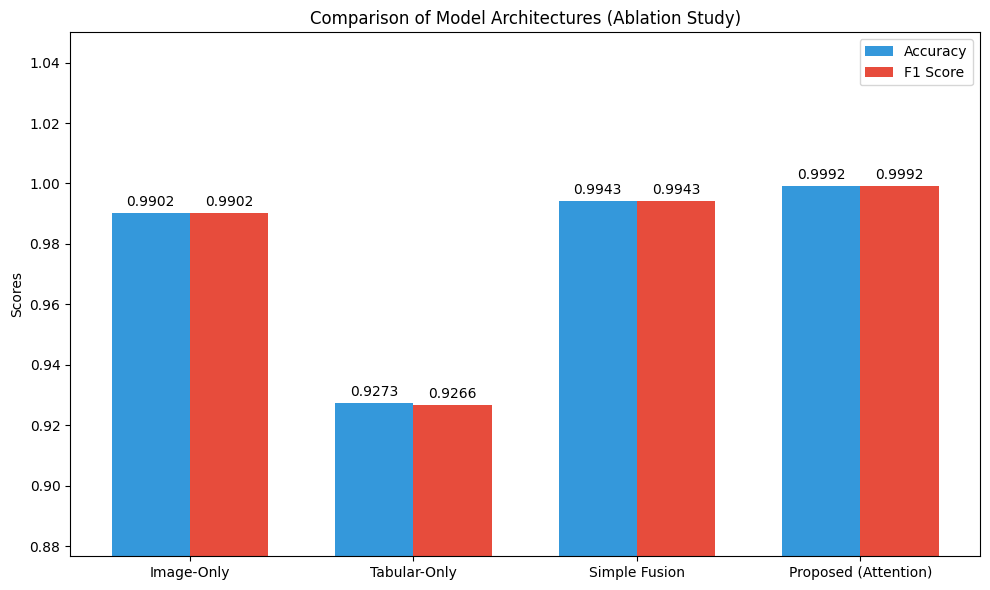

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_results = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})
print(df_results)

x = np.arange(len(df_results['Model']))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, df_results['Acc'], width, label='Accuracy', color='#3498db')
rects2 = ax.bar(x + width/2, df_results['F1'], width, label='F1 Score', color='#e74c3c')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Architectures (Ablation Study)')
ax.set_xticks(x)
ax.set_xticklabels(df_results['Model'])
ax.legend()

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.ylim(min(df_results['F1'].min(), df_results['Acc'].min()) - 0.05, 1.05)
plt.tight_layout()
plt.savefig('ablation_comparison.png')

# **Training Function**

In [37]:
# def train_ablation(model, name, epochs=10):
#     print(f"\n--- Training Ablation: {name} ---")
#     model = model.to(CONFIG['DEVICE'])
#     optimizer = optim.Adam(model.parameters(), lr=1e-4)
#     criterion = nn.CrossEntropyLoss(weight=class_weights)
    
#     best_acc = 0
#     for epoch in range(epochs):
#         model.train()
#         for imgs, tabs, lbls in train_loader:
#             imgs, tabs, lbls = imgs.to(CONFIG['DEVICE']), tabs.to(CONFIG['DEVICE']), lbls.to(CONFIG['DEVICE'])
#             optimizer.zero_grad()
#             outputs = model(imgs, tabs)
#             loss = criterion(outputs, lbls)
#             loss.backward()
#             optimizer.step()
            
#     model.eval()
#     y_true, y_pred = [], []
#     with torch.no_grad():
#         for imgs, tabs, lbls in test_loader:
#             imgs, tabs, lbls = imgs.to(CONFIG['DEVICE']), tabs.to(CONFIG['DEVICE']), lbls.to(CONFIG['DEVICE'])
#             outputs = model(imgs, tabs)
#             _, preds = torch.max(outputs, 1)
#             y_true.extend(lbls.cpu().numpy())
#             y_pred.extend(preds.cpu().numpy())
    
#     acc = accuracy_score(y_true, y_pred)
#     f1 = f1_score(y_true, y_pred, average='weighted')
#     print(f"Results for {name}: Acc: {acc:.4f}, F1: {f1:.4f}")
#     return acc, f1

# **Visualization of Results**

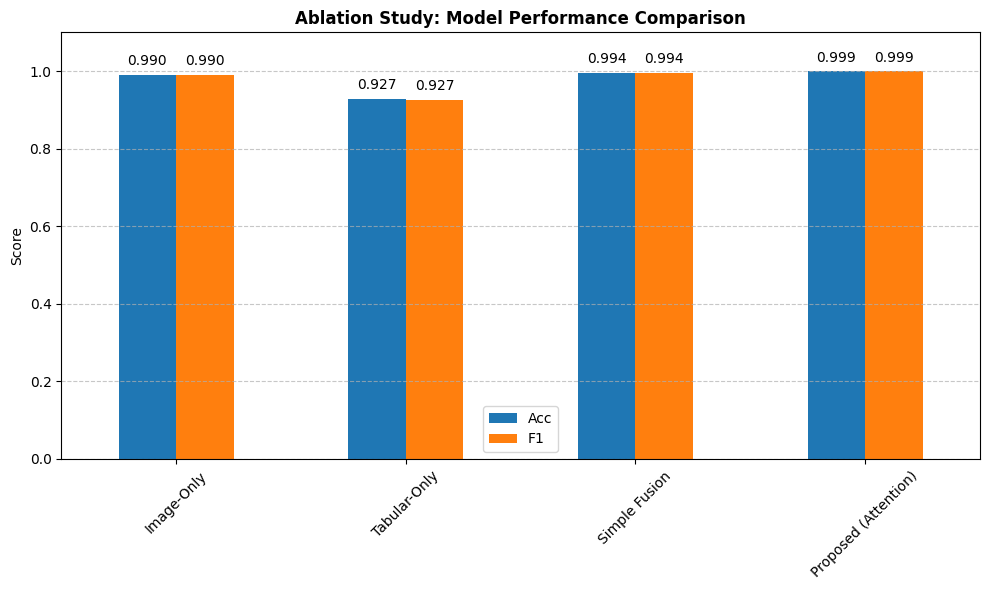

In [38]:
import pandas as pd

df_results = pd.DataFrame(results).T

ax = df_results.plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Ablation Study: Model Performance Comparison', fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()

# **ROC, PR Curves, and Confusion Matrix Comparison**

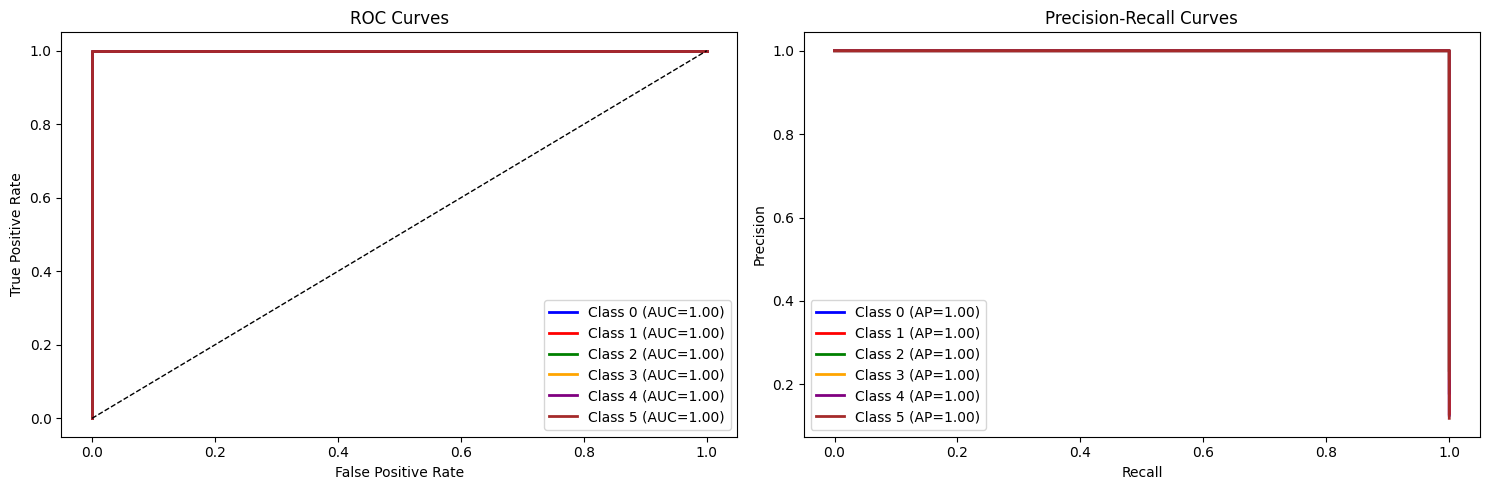

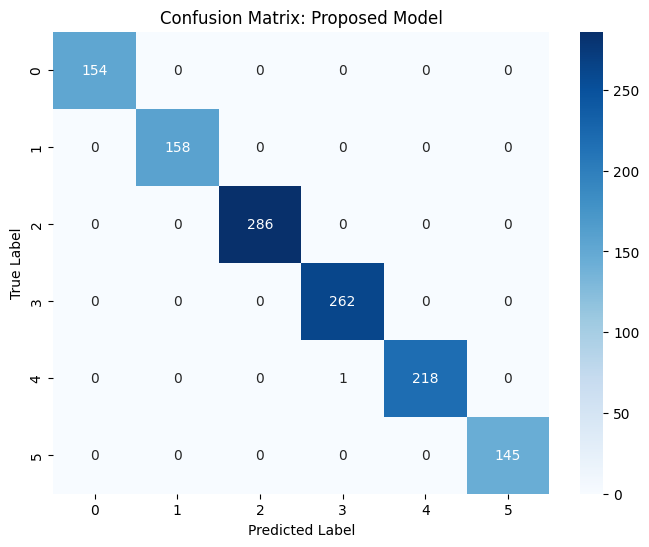

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns

y_true_bin = label_binarize(y_true, classes=range(CONFIG['NUM_CLASSES']))
n_classes = y_true_bin.shape[1]
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
    auc_val = roc_auc_score(y_true_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (AUC={auc_val:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_proba[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_proba[:, i])
    plt.plot(recall, precision, color=color, lw=2, label=f'Class {i} (AP={ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Proposed Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# **Advanced Metrics (MCC, Kappa, Jaccard)**

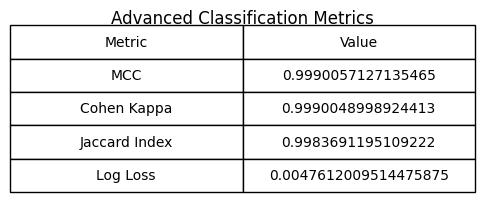

In [42]:
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, jaccard_score, log_loss

mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
jaccard = jaccard_score(y_true, y_pred, average='weighted')
logloss = log_loss(y_true, y_proba)

metrics_data = {
    'Metric': ['MCC', 'Cohen Kappa', 'Jaccard Index', 'Log Loss'],
    'Value': [mcc, kappa, jaccard, logloss]
}

fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=pd.DataFrame(metrics_data).values, 
                 colLabels=pd.DataFrame(metrics_data).columns, 
                 loc='center', cellLoc='center')
table.scale(1, 2)
table.set_fontsize(12)
plt.title("Advanced Classification Metrics")
plt.show()

# **Push Model to HuggingFace**

In [43]:
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login, HfApi

user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("aqi")

if hf_token:
    login(token=hf_token)
    print("Successfully logged in to Hugging Face Hub")
else:
    print("aqi not found in Kaggle Secrets!")

Successfully logged in to Hugging Face Hub


In [44]:
from huggingface_hub import HfApi, login

checkpoint = {
    'model_state_dict': fusion_model.state_dict(),
    'class_map': class_map,
    'config': CONFIG,
    'num_tab_features': len(feature_cols) 
}

save_path = "multimodal_aqi_model.pth"
torch.save(checkpoint, save_path)

repo_id = "rocky250/aqi-multimodal" 

api = HfApi()
api.create_repo(repo_id=repo_id, exist_ok=True)

print(f"Uploading {save_path} to {repo_id}...")
api.upload_file(
    path_or_fileobj=save_path,
    path_in_repo="model.pth", 
    repo_id=repo_id
)

print(f"Model pushed to: https://huggingface.co/{repo_id}")

Uploading multimodal_aqi_model.pth to rocky250/aqi-multimodal...


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Model pushed to: https://huggingface.co/rocky250/aqi-multimodal
